In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [117]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join([itos[i] for i in context]), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [119]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [166]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10))
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
sum(p.numel() for p in parameters) # total number of parameters

11897

In [167]:
for p in parameters:
    p.requires_grad = True

In [168]:
lri = []
lossi = []
stepi = []

In [179]:
# Train model
# TODO: Beat Karpathy on dev. He got 2.17.

# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre

for i in range(200000):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    # forward pass
    emb = C[Xtr[ix]] # look up embeddings -> (32, 3, 2) only for minibatch
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # -1 means "infer this dimension"
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())


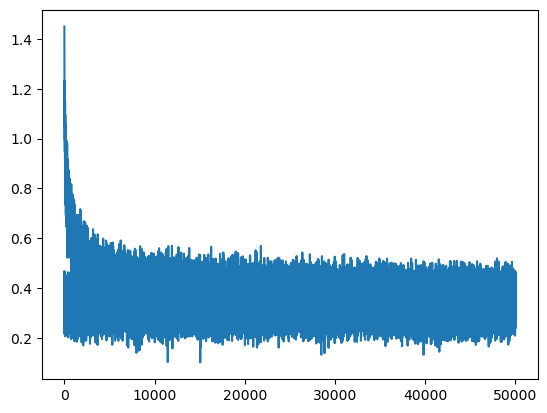

In [180]:
plt.plot(stepi, lossi)

In [181]:
print(loss.item())

1.865096926689148


In [182]:
# Evaluate model on training

emb = C[Xtr] # look up embeddings for all of X -> (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # -1 means "infer this dimension" -> (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1658, grad_fn=<NllLossBackward0>)

In [183]:
# Evaluate model on dev

emb = C[Xdev] # look up embeddings for all of X -> (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # -1 means "infer this dimension" -> (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1930, grad_fn=<NllLossBackward0>)

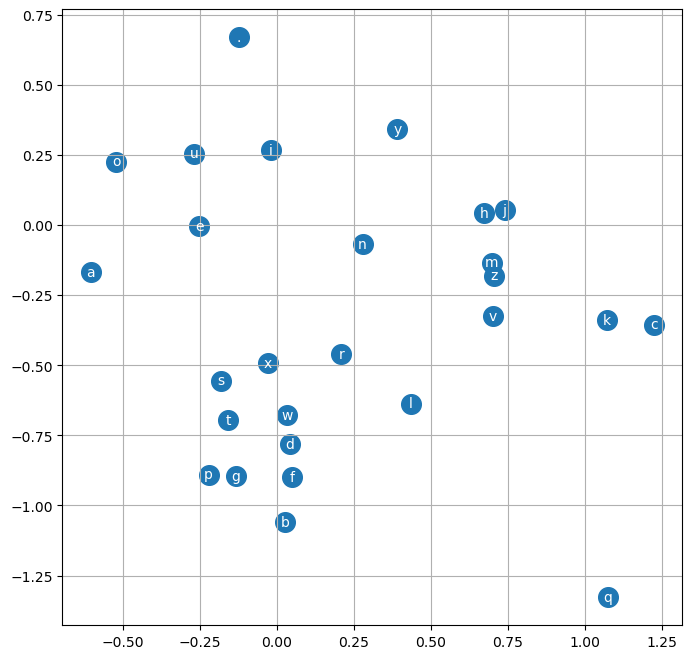

In [162]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [184]:
# inference

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join([itos[i] for i in out]))

mora.
amyan.
see.
med.
ryla.
remyra.
endrade.
aderediel.
izely.
jen.
edeighananarahmy.
kohmara.
noshubergihahiel.
kendretlynn.
novana.
uba.
ged.
ryyshan.
els.
kayshven.
